In [2]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 2.1MB 10.1MB/s 
     |████████████████████████████████| 204kB 56.7MB/s 
     |████████████████████████████████| 3.3MB 54.6MB/s 
     |████████████████████████████████| 901kB 59.0MB/s 
     |████████████████████████████████| 245kB 54.2MB/s 
     |████████████████████████████████| 112kB 56.8MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [5]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][242]

1

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [6]:
# оригинальная версия 
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][34], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72,   460,   256,  5967,   257,  1103,  1204,  8883,   810,  1312,
           561,   307, 17991,  5884,  1576,   351,  2130,   284,  1254,  6635,
          6292,   290,  3338,   810,   340,   340, 22388, 10909,   329,   502,
           284,   423,  1969,   290, 20573,  3518,  2800,   290,   810,  1714,
          1839,   256,   307,  2938, 12412, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [7]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = emotion_dataset[self.part]["text"][idx]
        label = emotion_dataset[self.part]["label"][idx]
        
        tokenizer_output = tokenizer(text, max_length=self.max_length, padding="max_length", return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'],
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [8]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation')
test_dataset = TweetDataset('test')

In [9]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6,
    use_cache=False
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
batch = next(iter(train_loader))

tokens = batch['input_ids'].squeeze(1).to(device) # Получи токены из датасета
mask = batch['mask'].squeeze(1).to(device) # Получи маску из датасета
labels = batch['target'].to(device)

model_out = model_0(input_ids=tokens, attention_mask=mask)
model_out.keys()

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-6 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, last_epoch=-1, verbose=False) # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 6

# Train loop
for e in range(num_epochs):
    print(f' epoch №{e+1}')
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        
        
        # unpacking batches
        tokens = batch['input_ids'].squeeze(1).to(device)
        mask = batch['mask'].squeeze(1).to(device)
        labels = batch['target'].to(device)

        optimizer.zero_grad()
        # loading the model
        model_output = model_0(input_ids=tokens, attention_mask=mask)
        
        loss = criterion(model_output['logits'], labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            
            tokens = batch['input_ids'].squeeze(1).to(device)
            mask = batch['mask'].squeeze(1).to(device)
            labels = batch['target'].to(device)
            
            model_output = model_0(input_ids=tokens, attention_mask=mask)
            loss = criterion(model_output['logits'], labels)

            valid_loss += loss.item()
            valid_acc += (labels == torch.argmax(model_output['logits'], dim=1)).sum().item() 
    
    scheduler.step()
    print("Train Loss: {:.3f}".format(train_loss / len(train_loader)),
          "Valid Loss: {:.3f}".format(valid_loss / len(valid_loader)),
          "Valid Acc:  {:.2f}".format(valid_acc / len(valid_loader)))
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        
        tokens = batch['input_ids'].squeeze(1).to(device)
        mask = batch['mask'].squeeze(1).to(device)
        labels = batch['target'].to(device)

        model_output = model_0(input_ids=tokens, attention_mask=mask)
        test_acc += (labels == torch.argmax(model_output['logits'], dim=1)).sum().item() 

print("Test Acc: {:.3f}".format(test_acc / len(test_loader)))

 epoch №1



Train Loss: 0.124 Valid Loss: 0.544 Valid Acc:  52.62
 epoch №2



Train Loss: 0.128 Valid Loss: 0.544 Valid Acc:  52.62
 epoch №3



Train Loss: 0.126 Valid Loss: 0.544 Valid Acc:  52.62
 epoch №4



Train Loss: 0.124 Valid Loss: 0.544 Valid Acc:  52.62
 epoch №5



Train Loss: 0.130 Valid Loss: 0.544 Valid Acc:  52.62
 epoch №6



Train Loss: 0.124 Valid Loss: 0.544 Valid Acc:  52.62
Test Acc: 52.656


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [13]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [14]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def f(x):
    return x if len(x)==1 else x[1:]

text = emotion_dataset["test"]["text"][765]
tokens = [*map(f, tokenizer.tokenize(text))]

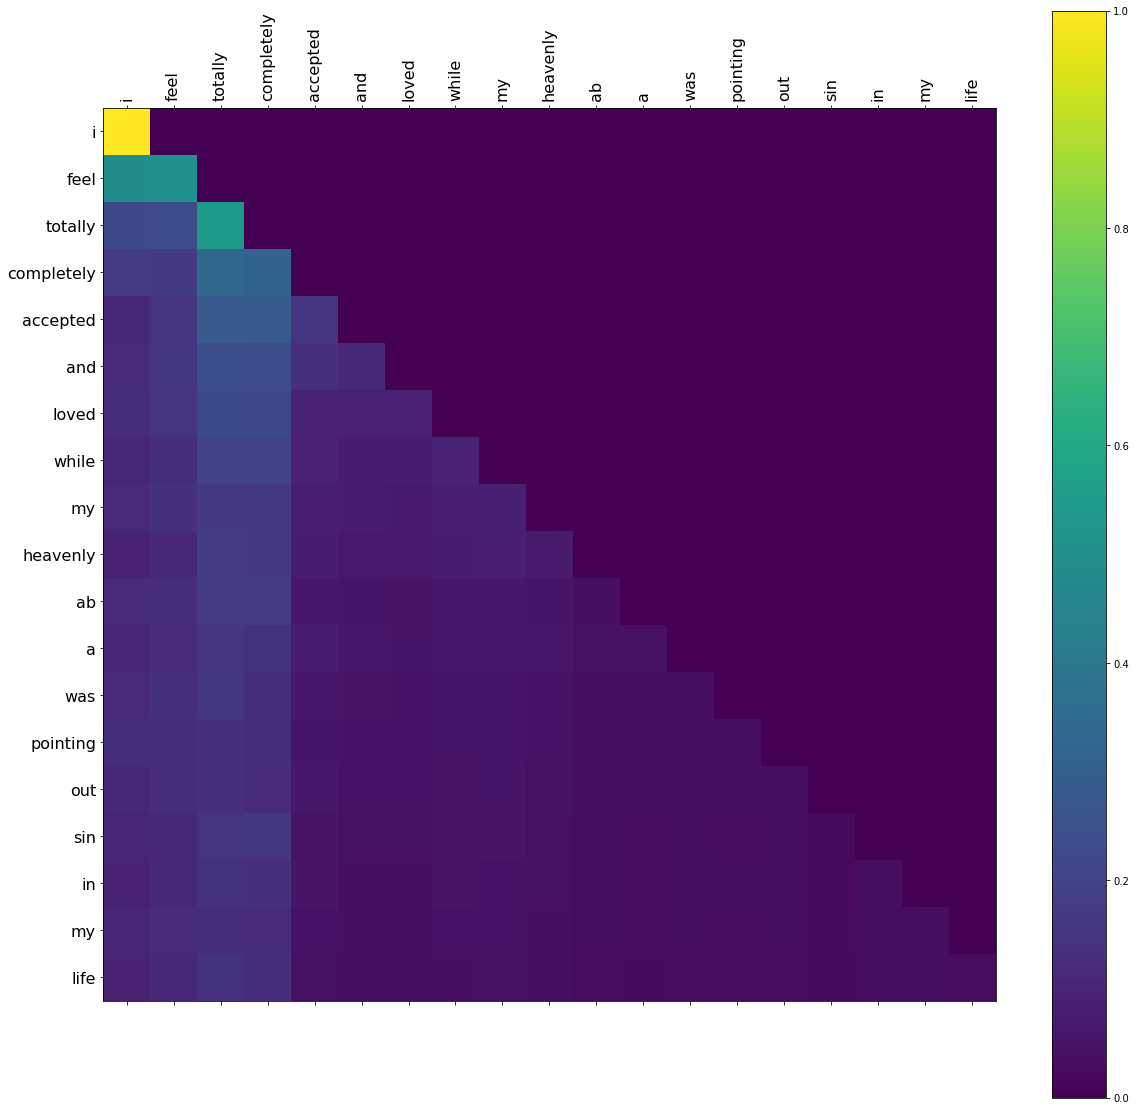

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [10]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6,
    use_cache=False
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1, verbose=False) # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [12]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    print(f' epoch №{e+1}')
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):

        tokens = batch['input_ids'].squeeze(1).to(device)
        mask = batch['mask'].squeeze(1).to(device)
        labels = batch['target'].to(device)

        optimizer.zero_grad()
        # loading the model
        model_output = model_1(input_ids=tokens, attention_mask=mask)
        
        
        loss = criterion(model_output['logits'], labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            
            tokens = batch['input_ids'].squeeze(1).to(device)
            mask = batch['mask'].squeeze(1).to(device)
            labels = batch['target'].to(device)
            
            model_output = model_1(input_ids=tokens, attention_mask=mask)
            loss = criterion(model_output['logits'], labels)

            valid_loss += loss.item()
            valid_acc += (labels == torch.argmax(model_output['logits'], dim=1)).sum().item() 
    
    #scheduler.step()
    print("Train Loss: {:.3f}".format(train_loss / len(train_loader)),
          "Valid Loss: {:.3f}".format(valid_loss / len(valid_loader)),
          "Valid Acc: {:.2f}".format(valid_acc / len(valid_loader)))
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        
        tokens = batch['input_ids'].squeeze(1).to(device)
        mask = batch['mask'].squeeze(1).to(device)
        labels = batch['target'].to(device)

        model_output = model_1(input_ids=tokens, attention_mask=mask)
        test_acc += (labels == torch.argmax(model_output['logits'], dim=1)).sum().item() 

print("Test Acc: {:.2f}".format(test_acc / len(test_loader)))

 epoch №1



Train Loss: 1.562 Valid Loss: 1.030 Valid Acc: 40.78
 epoch №2



Train Loss: 0.709 Valid Loss: 0.415 Valid Acc: 53.97
 epoch №3



Train Loss: 0.364 Valid Loss: 0.249 Valid Acc: 57.03
 epoch №4



Train Loss: 0.252 Valid Loss: 0.193 Valid Acc: 57.62
 epoch №5



Train Loss: 0.200 Valid Loss: 0.166 Valid Acc: 57.94
 epoch №6



Train Loss: 0.172 Valid Loss: 0.167 Valid Acc: 57.84
 epoch №7



Train Loss: 0.155 Valid Loss: 0.148 Valid Acc: 58.53
 epoch №8



Train Loss: 0.143 Valid Loss: 0.145 Valid Acc: 58.22
 epoch №9



Train Loss: 0.131 Valid Loss: 0.141 Valid Acc: 58.28
 epoch №10



Train Loss: 0.121 Valid Loss: 0.140 Valid Acc: 58.25
Test Acc: 57.66


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [17]:
def f(x):
    return x if len(x)==1 else x[1:]

text = emotion_dataset["test"]["text"][765]
tokens = [*map(f, tokenizer.tokenize(text))]

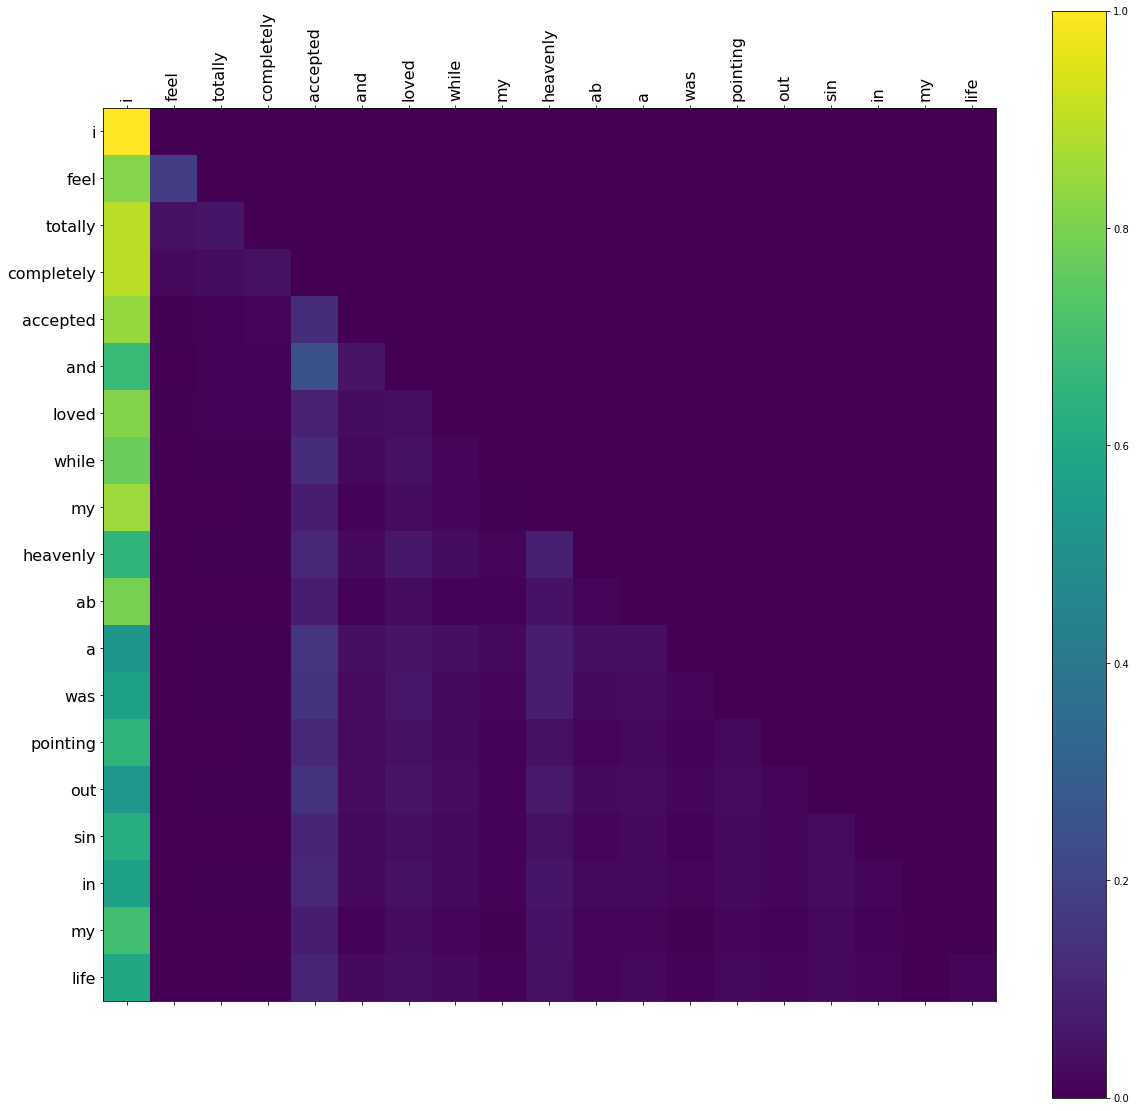

In [19]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

Вторая модель дает лучше результат (`0.577 > 0.526`). Это в первую очередь свзанно с тем, что вторая модель уже натренирована на большем датасете, и мы ее только подгоняем под наш, тогда как первой модели необходимо полностью самостоятельно выучивать новый датасет целиком, из-за этого ее качество хуже. 

Наибольшее внимания модель образает на местоимения, глаголы и прилогательные. Стоит отметить, что вторая модель больше внимания уделяет словам во второй половине предложения ближе к коцу по сравнению с первой моделью. Это значит, что вторяя модель "более внимательная" и умеет вычленять больше информации из датасета.
